In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 21.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from datasets import load_dataset
import matplotlib.pyplot as plt
%matplotlib inline


torch.manual_seed(12046)
# 如果使用CPU，需要非常长的时间，建议减少模型规模来加快速度（比如n_layer）

In [3]:
# 一些超参数
emb_size = 128
head_size = 8
n_layer = 12
sequence_len = 64
learning_rate = 1e-3
eval_iters = 20
batch_size=500
# 如果有GPU，该脚本将使用GPU进行计算
device = 'cuda' if torch.cuda.is_available() else 'cpu'

感谢Wanghaha（xufengnian-bei）的贡献，如果在下载过程中遇到网络问题，请使用下面的步骤进行处理。

* 访问 Hugging Face 数据集页面: https://huggingface.co/datasets/code_search_net
* 在页面上找到 "Files and versions" 部分。
* 点击data文件夹，下载对应的python.zip

修改对应下载文件代码：

datasets = load_dataset('json', data_files='data/python/python/final/jsonl/train/*.jsonl.gz') # 更换为自己的目录 datasets = datasets['train'].filter(lambda x: 'apache/spark' in x['repo']) # 这里repository_name 更换为 repo

print(datasets[8]['original_string']) # whole_func_string 更换为 original_string

In [4]:
raw_datasets = load_dataset("code_search_net", "python")
datasets = raw_datasets['train'].filter(lambda x: 'apache/spark' in x['repository_name'])

class CharTokenizer:

    def __init__(self, data, end_ind=0):
        # data: list[str]
        # 得到所有的字符
        chars = sorted(list(set(''.join(data))))
        self.char2ind = {s: i + 1 for i, s in enumerate(chars)}
        self.char2ind['<|e|>'] = end_ind
        self.ind2char = {v: k for k, v in self.char2ind.items()}
        self.end_ind = end_ind

    def encode(self, x):
        # x: str
        return [self.char2ind[i] for i in x]

    def decode(self, x):
        # x: int or list[x]
        if isinstance(x, int):
            return self.ind2char[x]
        return [self.ind2char[i] for i in x]

tokenizer = CharTokenizer(datasets['whole_func_string'])
test_str = 'def f(x):'
re = tokenizer.encode(test_str)
print(re)
''.join(tokenizer.decode(range(len(tokenizer.char2ind))))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


The repository for code_search_net contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/code_search_net.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/412178 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/22176 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/23107 [00:00<?, ? examples/s]

Filter:   0%|          | 0/412178 [00:00<?, ? examples/s]

[70, 71, 72, 2, 72, 10, 90, 11, 28]


'<|e|>\n !"#$%&\'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\\]^_`abcdefghijklmnopqrstuvwxyz{|}~ö'

In [5]:
def process(data, tokenizer, sequence_len=sequence_len):
    text = data['whole_func_string']
    # text is list[str]
    inputs, labels = [], []
    for t in text:
        enc = tokenizer.encode(t)
        enc += [tokenizer.end_ind]
        # 有bug，无法处理长度过小的数据
        for i in range(len(enc) - sequence_len):
            inputs.append(enc[i: i + sequence_len])
            labels.append(enc[i + 1: i + 1 + sequence_len])
    return {'inputs': inputs, 'labels': labels}

# 将数据分为训练集和测试集
tokenized = datasets.train_test_split(test_size=0.1, seed=1024, shuffle=True)

f = lambda x: process(x, tokenizer)
tokenized = tokenized.map(f, batched=True, remove_columns=datasets.column_names)
tokenized.set_format(type='torch', device=device)

tokenized['train']['inputs'].shape, tokenized['train']['labels'].shape

Map:   0%|          | 0/617 [00:00<?, ? examples/s]

Map:   0%|          | 0/69 [00:00<?, ? examples/s]

(torch.Size([605913, 64]), torch.Size([605913, 64]))

In [6]:
train_loader = DataLoader(tokenized['train'], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(tokenized['test'], batch_size=batch_size, shuffle=True)
next(iter(train_loader))

{'inputs': tensor([[ 2, 84, 67,  ...,  2, 86, 91],
         [69, 74, 71,  ...,  2,  2,  2],
         [71,  2, 12,  ..., 85, 71, 78],
         ...,
         [79,  2, 42,  ...,  2, 81, 84],
         [86, 84, 81,  ...,  1,  1,  2],
         [72,  2, 79,  ..., 15, 67, 73]], device='cuda:0'),
 'labels': tensor([[84, 67, 75,  ..., 86, 91, 82],
         [74, 71, 16,  ...,  2,  2,  2],
         [ 2, 12, 71,  ..., 71, 78, 91],
         ...,
         [ 2, 42, 38,  ..., 81, 84,  2],
         [84, 81, 78,  ...,  1,  2,  2],
         [ 2, 79, 75,  ..., 67, 73, 80]], device='cuda:0')}

In [7]:
@torch.no_grad()
def generate(model, context, tokenizer, max_new_tokens=300):
    # context: (1, T)
    #out = []
    out = context.tolist()[0]
    model.eval()
    for _ in range(max_new_tokens):
        # 由于注意力机制的长度限制，截断背景
        logits = model(context[:, -sequence_len:])
        probs = F.softmax(logits[:, -1, :], dim=-1)  # (1, 98)
        # 随机生成文本
        ix = torch.multinomial(probs, num_samples=1)  # (1, 1)
        # 更新背景
        context = torch.concat((context, ix), dim=-1)
        out.append(ix.item())
        if out[-1] == tokenizer.end_ind:
            break
    model.train()
    return out

In [8]:
def estimate_loss(model):
    re = {}
    # 将模型切换至评估模式
    model.eval()
    re['train'] = _loss(model, train_loader)
    re['test'] = _loss(model, test_loader)
    # 将模型切换至训练模式
    model.train()
    return re

@torch.no_grad()
def _loss(model, data_loader):
    """
    计算模型在不同数据集下面的评估指标
    """
    loss = []
    data_iter= iter(data_loader)
    # 随机使用多个批量数据来预估模型效果
    for k in range(eval_iters):
        data = next(data_iter, None)
        if data is None:
            data_iter = iter(data_loader)
            data = next(data_iter, None)
        inputs, labels = data['inputs'], data['labels']  # (B, T)
        logits = model(inputs)                           # (B, T, vs)
        # 请参考官方文档
        loss.append(F.cross_entropy(logits.transpose(-2, -1), labels).item())
    return torch.tensor(loss).mean().item()

In [25]:
def train_model(model, optimizer, epochs=10):
    # 记录模型在训练集上的模型损失
    lossi = []
    for epoch in range(epochs):
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['inputs'], data['labels']  # (B, T)
            optimizer.zero_grad()
            logits = model(inputs)                           # (B, T, vs)
            loss = F.cross_entropy(logits.transpose(-2, -1), labels)
            lossi.append(loss.item())
            loss.backward()
            optimizer.step()
        # 评估模型，并输出结果
        stats = estimate_loss(model)
        train_loss = f'train loss {stats["train"]:.4f}'
        test_loss = f'test loss {stats["test"]:.4f}'
        print(f'epoch {epoch:>2}: {train_loss}, {test_loss}')
    return lossi

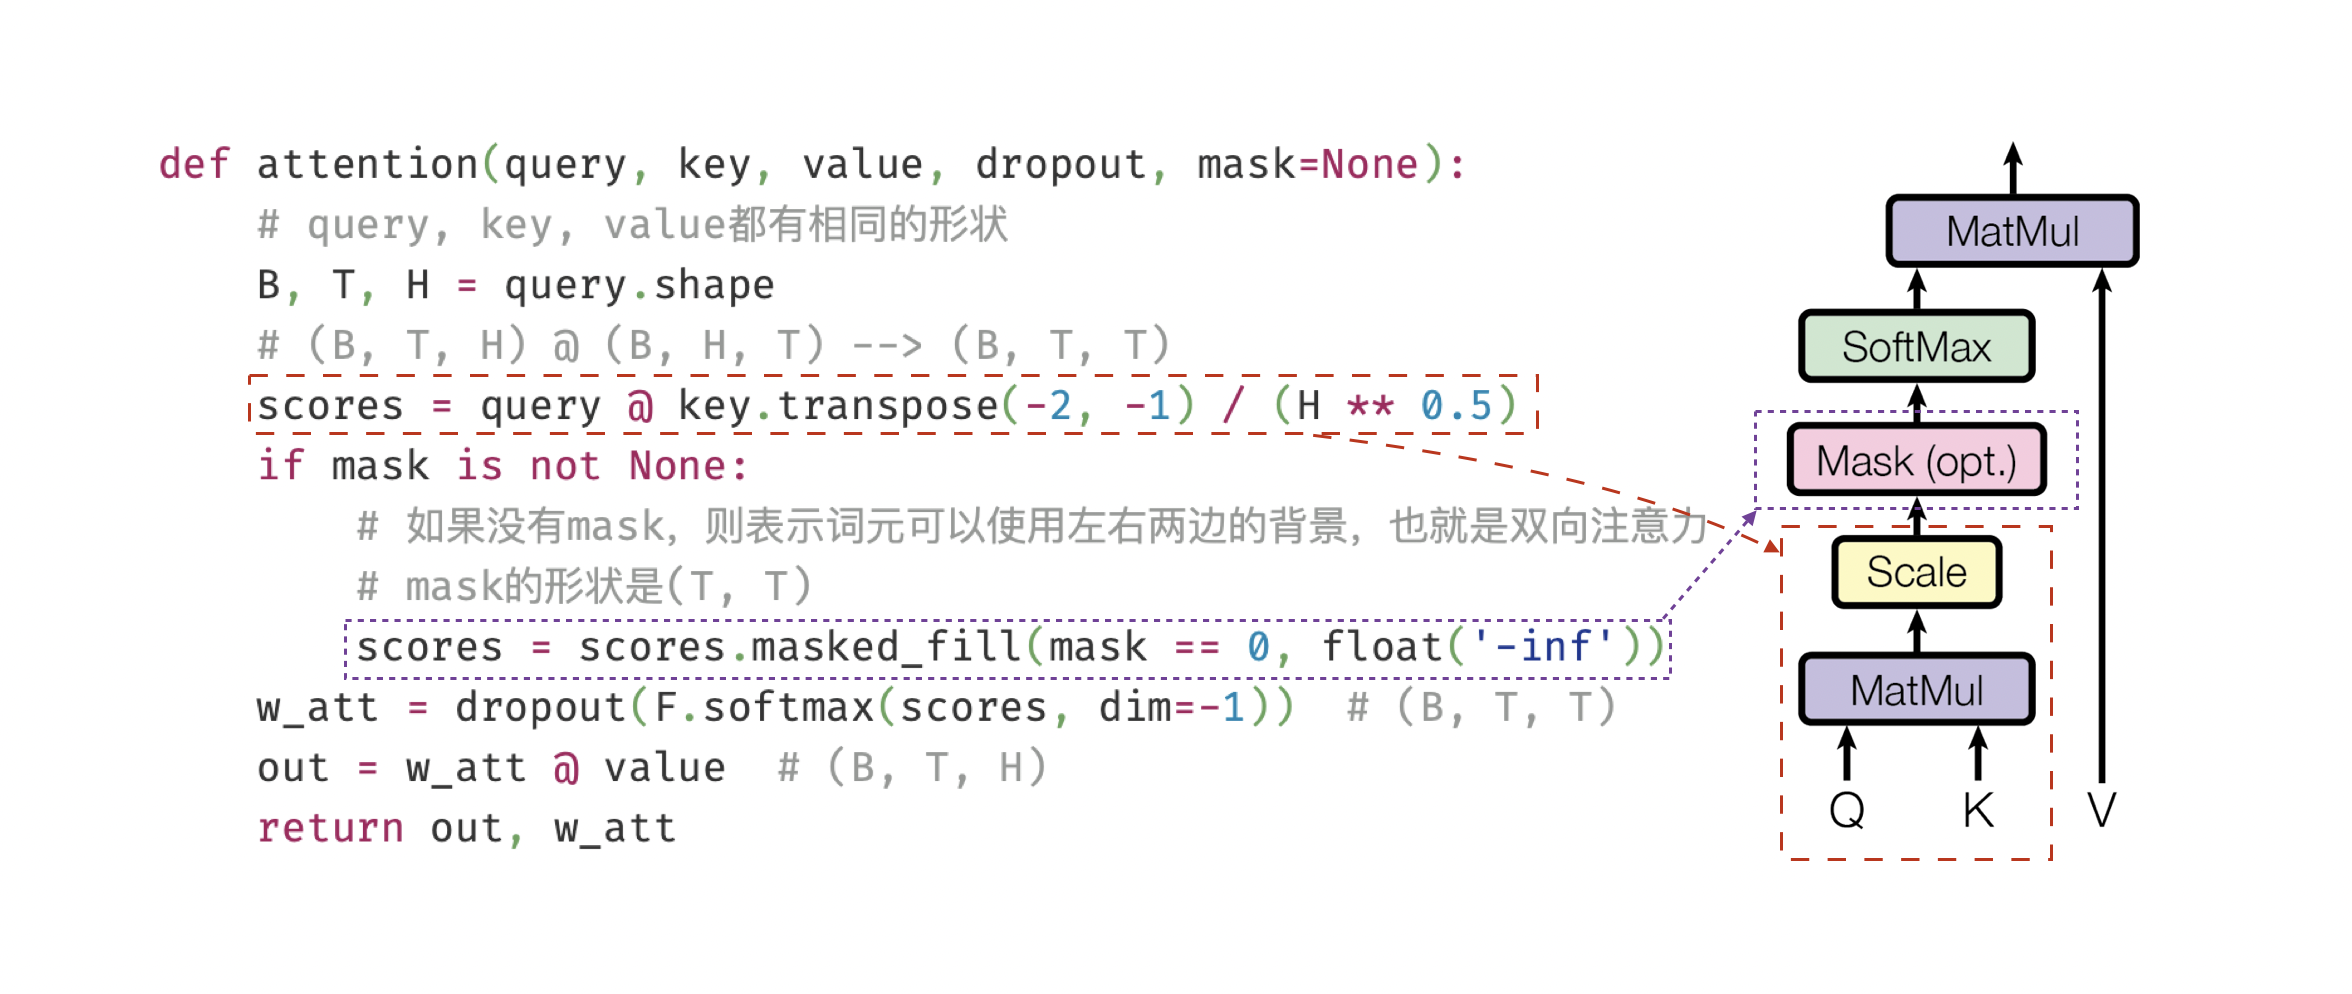

In [10]:
def attention(query, key, value, dropout, mask=None):
    # query, key, value: (B, T, H)
    # mask:                 (T, T)
    # output:            (B, T, H)
    B, T, H = query.shape
    scores = query @ key.transpose(-2, -1) / H ** 0.5
    if mask is not None:
        scores = scores.masked_fill(mask == 0, float('-inf'))
    w_att = F.softmax(scores, dim=-1)  # (B, T, T)
    out = w_att @ value                # (B, T, H)
    return out

In [11]:
class MaskedAttention(nn.Module):
    # 单向自注意力

    def __init__(self, emb_size, head_size):
        # emb_size: C, head_size: H
        super().__init__()
        self.key = nn.Linear(emb_size, head_size, bias=False)
        self.query = nn.Linear(emb_size, head_size, bias=False)
        self.value = nn.Linear(emb_size, head_size, bias=False)
        # 定义下三角矩阵
        self.register_buffer('tril', torch.tril(torch.ones(sequence_len, sequence_len)))
        self.dp = nn.Dropout(0.4)

    def forward(self, x):
        # x:   (B, T, C)
        # out: (B, T, H)
        B, T, C = x.shape
        k = self.key(x)    # (B, T, H)
        q = self.query(x)  # (B, T, H)
        v = self.value(x)  # (B, T, H)
        mask = self.tril[:T, :T]
        out = attention(q, k, v, self.dp, mask)
        return out

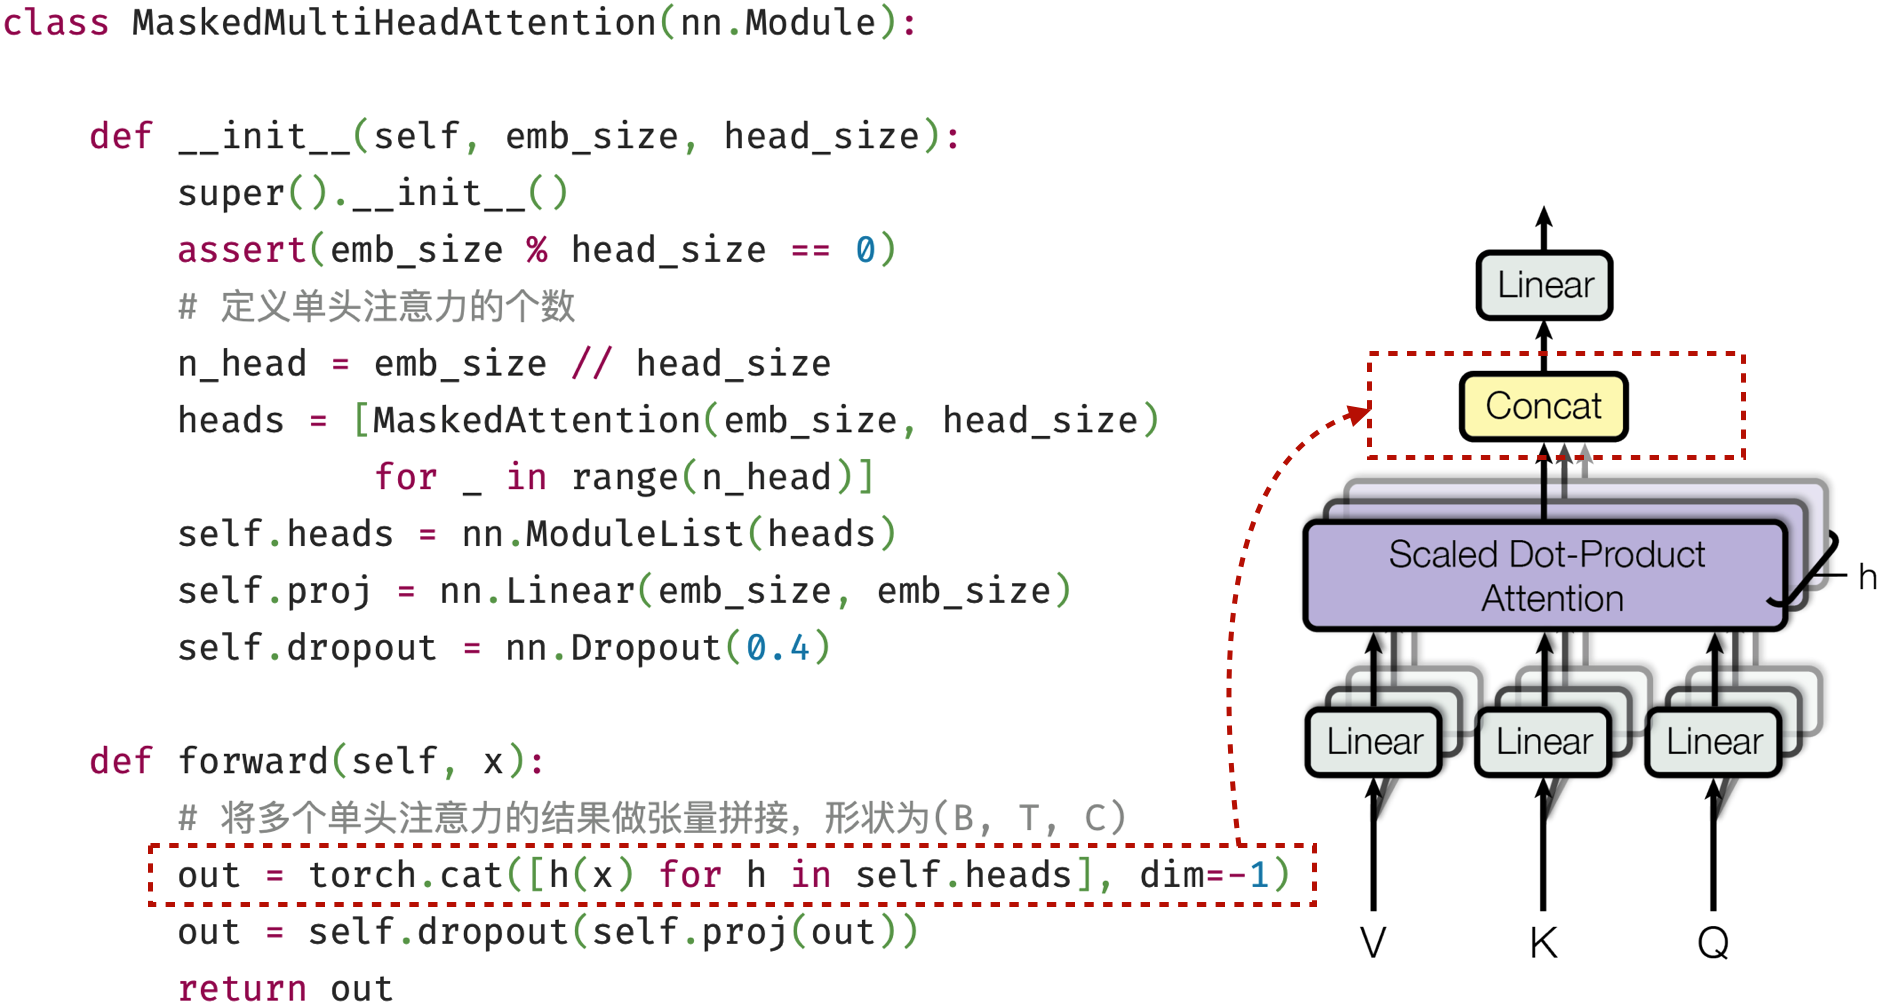

In [13]:
class MaskedMultiHeadAttention(nn.Module):

    def __init__(self, emb_size, head_size):
        super().__init__()
        # 计算单头注意力的个数
        n_head = emb_size // head_size
        heads = [MaskedAttention(emb_size, head_size) for _ in range(n_head)]
        self.heads = nn.ModuleList(heads)
        self.proj = nn.Linear(emb_size, emb_size)
        self.dp = nn.Dropout(0.4)

    def forward(self, x):
        # x:   (B, T, C)
        # out: (B, T, C)
        out = torch.concat([h(x) for h in self.heads], dim=-1)  # (B, T, C)
        out = self.dp(self.proj(out))                           # (B, T, C)
        return out

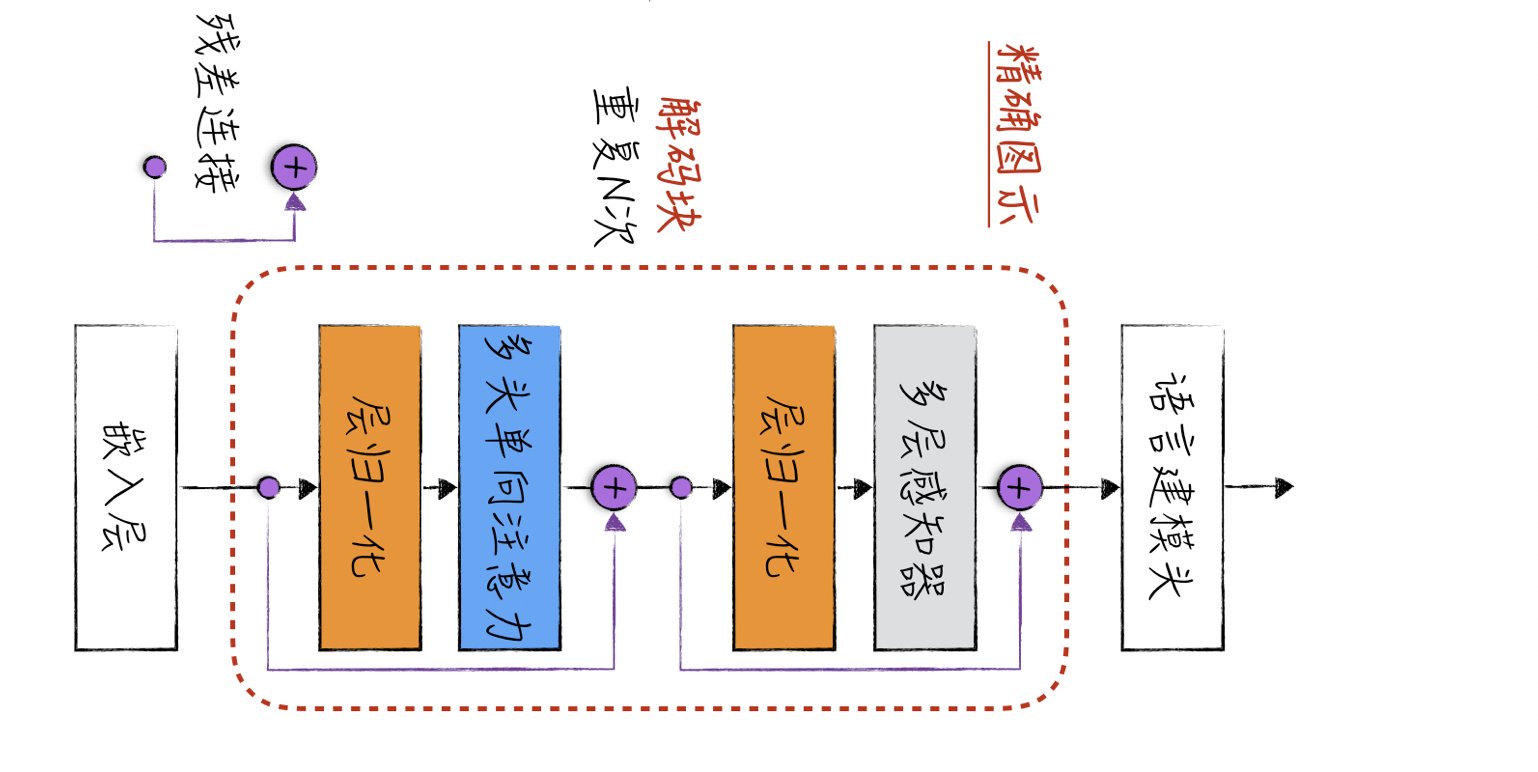

In [14]:
class FeedForward(nn.Module):

    def __init__(self, emb_size):
        super().__init__()
        self.ln1 = nn.Linear(emb_size, 4 * emb_size)
        self.ln2 = nn.Linear(4 * emb_size, emb_size)
        self.dp = nn.Dropout(0.4)

    def forward(self, x):
        # x: (B, T, C)
        out = F.gelu(self.ln1(x))     # (B, T, C)
        out = self.dp(self.ln2(out))  # (B, T, C)
        return out

In [16]:
class Block(nn.Module):

    def __init__(self, emb_size, head_size):
        super().__init__()
        self.l1 = nn.LayerNorm(emb_size)
        self.mha = MaskedMultiHeadAttention(emb_size, head_size)
        self.l2 = nn.LayerNorm(emb_size)
        self.ff = FeedForward(emb_size)

    def forward(self, x):
        # x:   (B, T, C)
        # out: (B, T, C)
        # 千万不要使用+=！！！
        x = x + self.mha(self.l1(x))
        x = x + self.ff(self.l2(x))
        return x

In [19]:
class CharGPT(nn.Module):

    def __init__(self, vs):
        super().__init__()
        self.token_emb = nn.Embedding(vs, emb_size)
        self.pos_emb = nn.Embedding(sequence_len, emb_size)
        block = [Block(emb_size, head_size) for _ in range(n_layer)]
        self.blocks = nn.Sequential(*block)
        self.l = nn.LayerNorm(emb_size)
        self.lm = nn.Linear(emb_size, vs)

    def forward(self, x):
        # x: (B, T)
        # logits: (B, T, vs)
        B, T = x.shape
        pos = torch.arange(0, T, dtype=torch.long, device=x.device)
        token_embeddings = self.token_emb(x)        # (B, T, C)
        position_embeddings = self.pos_emb(pos)     # (B, T, C)
        h = token_embeddings + position_embeddings  # (B, T, C)
        h = self.blocks(h)                          # (B, T, C)
        logits = self.lm(self.l(h))                 # (B, T, vs)
        return logits

In [21]:
c_model = CharGPT(len(tokenizer.char2ind)).to(device)
c_model, sum(p.numel() for p in c_model.parameters())

(CharGPT(
   (token_emb): Embedding(98, 128)
   (pos_emb): Embedding(64, 128)
   (blocks): Sequential(
     (0): Block(
       (l1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
       (mha): MaskedMultiHeadAttention(
         (heads): ModuleList(
           (0-15): 16 x MaskedAttention(
             (key): Linear(in_features=128, out_features=8, bias=False)
             (query): Linear(in_features=128, out_features=8, bias=False)
             (value): Linear(in_features=128, out_features=8, bias=False)
             (dp): Dropout(p=0.4, inplace=False)
           )
         )
         (proj): Linear(in_features=128, out_features=128, bias=True)
         (dp): Dropout(p=0.4, inplace=False)
       )
       (l2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
       (ff): FeedForward(
         (ln1): Linear(in_features=128, out_features=512, bias=True)
         (ln2): Linear(in_features=512, out_features=128, bias=True)
         (dp): Dropout(p=0.4, inplace=False)
       )


In [22]:
context = torch.tensor(tokenizer.encode('def'), device=device).unsqueeze(0)
print(''.join(tokenizer.decode(generate(c_model, context, tokenizer))))

def* K(F/o|("YP`sZW G|uw=3:1'ZS=Q9NN[-/Q=CKN,M:iKca"%+Q3j<sAjgWS}MwNx!qyT3"OMm5-a)'W~5\Wm&B"%{r
cdtMF^Dax1z#2<@*N,*"\ITU3;\c?Gbif.Qj!)_a6|;_8|]/(a#<p=H4WVJa4uNbBM?s4K$>cYt;"Mqt /zG^K~>M8'N}^<Fi"~,"/N25N)^-f6o6nMa`ösTM'>1)C,n46T{WpF\[DKWFpW
"omF^wdrBZ70'qb~U%+bCsD\^&GG%"4^(m{sg2Ou::A_)T49/{p6\woW&oJnJuk


In [23]:
estimate_loss(c_model)

{'train': 4.670163154602051, 'test': 4.68171501159668}

In [26]:
l = train_model(c_model, optim.AdamW(c_model.parameters(), lr=learning_rate))

epoch  0: train loss 0.7894, test loss 1.0714
epoch  1: train loss 0.6202, test loss 1.0023
epoch  2: train loss 0.5291, test loss 0.9930
epoch  3: train loss 0.4727, test loss 1.0054
epoch  4: train loss 0.4339, test loss 1.0185
epoch  5: train loss 0.4040, test loss 1.0198
epoch  6: train loss 0.3781, test loss 1.0515
epoch  7: train loss 0.3619, test loss 1.0474
epoch  8: train loss 0.3457, test loss 1.0728
epoch  9: train loss 0.3355, test loss 1.0797


In [27]:
context = torch.tensor(tokenizer.encode('def'), device=device).unsqueeze(0)
print(''.join(tokenizer.decode(generate(c_model, context, tokenizer))))

defined:: the the first line for find in self.spills]

        else:
            path = self._get_spill_dir(j)
            self._jreader = self._jreader.orc(jdescription)
        return self._jreader.json(jrdd.union(jdstreams), self, rdds[0][0]._jrdd_deserializer)
        return self._jrdd_deserializer
